In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import spacy 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD 

In [17]:
df = pd.read_parquet("data/reviews_takeaway.parquet")

In [18]:
print(f"Nombre de reviews : {len(df)}")
df["comment"] = df["comment"].str.strip()  # Retirer les espaces en début ou fin de commentaire, pour aussi retirer les commentaires de type "  "
df = df[df["comment"] != ""]
print(f"Nombre de reviews avec un commentaire : {len(df)}")

Nombre de reviews : 20438
Nombre de reviews avec un commentaire : 18999


In [19]:
nlp = spacy.load("fr_core_news_md")

pipe = nlp.pipe(df["comment"], n_process=5,
                disable=["tagger", "parser", "attribute_ruler", "ner"])
def preprocess_token(token):
    if not (token.is_stop or token.is_punct) and token.is_alpha and len(token) >= 3:
        return token.lemma_
    else:
        return ""

def preprocess_text(text_nlp):
    text_pretraite_list = [preprocess_token(token) for token in text_nlp if token]
    text_pretraite = " ".join(text_pretraite_list)
    return text_pretraite

commentaires_pretraites = [preprocess_text(commentaire) for commentaire in pipe]

In [20]:
df["comment_pretraite"] = commentaires_pretraites

In [50]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=0, stratify=df['note'])


y_train = df_train["note"]
y_test = df_test["note"]

vectorizer = TfidfVectorizer(ngram_range=(1,3))

X_train = vectorizer.fit_transform(df_train["comment_pretraite"])
X_test = vectorizer.transform(df_test["comment_pretraite"])

voc = vectorizer.vocabulary_

#Creation du modele avec kernel defini
#A REVOIR PEUT ETRE
kernel = 'rbf'
gamma = 1e-4
C = 1e5

model = svm.SVC(C = C, kernel = kernel, gamma = gamma, probability = True, verbose=0, max_iter=2000 )

In [ ]:
tsvd = TruncatedSVD(15000)


In [51]:
import time
t1 = time.time()

model.fit(X_train,y_train) 

print("Fin de l'entrainement")

print("Execution : ", -t1 + time.time(), " s")

Fin de l'entrainement
Execution :  227.8691852092743  s


/opt/mamba/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


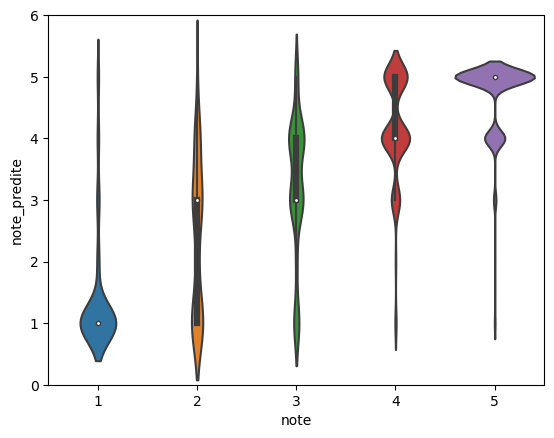

In [52]:
y_pred = model.predict(X_test)
y_pred

# Analyse qualitative
data = pd.DataFrame({'note': y_test, 'note_predite': y_pred})

sns.violinplot(x="note", y="note_predite", data=data)
ax = plt.gca()
ax.set_ylim(0, 6)
plt.show()

In [59]:
from sklearn.metrics import confusion_matrix

def accuracy(pred,real):
    """Calule la précision des prédictions pred par rapport à real """
    count = 0
    L = len(pred)
    for i in range(L):
        if pred[i] == real[i]:
            count += 1
    return count/L



          
print("Precision des prédiction : ", accuracy(y_pred,np.array(y_test)))
print("\n\nMatrice de confusion : ")
print(confusion_matrix(y_test, y_pred).round(2))
print(confusion_matrix(y_test, y_pred, normalize = 'pred' ).round(2))

Precision des prédiction :  0.636578947368421


Matrice de confusion : 
[[ 280   17   19   12   11]
 [  53   12   44   26    3]
 [  47   14  120  138   27]
 [  18    8  125  419  347]
 [  14    4   50  404 1588]]
[[0.68 0.31 0.05 0.01 0.01]
 [0.13 0.22 0.12 0.03 0.  ]
 [0.11 0.25 0.34 0.14 0.01]
 [0.04 0.15 0.35 0.42 0.18]
 [0.03 0.07 0.14 0.4  0.8 ]]


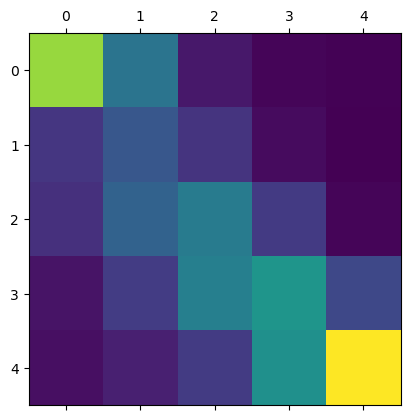

In [61]:
import matplotlib.pyplot as plt

plt.matshow(confusion_matrix(y_test, y_pred, normalize = 'pred' ))

In [66]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_squared_error(y_pred, y_test)


0.6797368421052632

In [67]:
mean_absolute_error(y_pred, y_test)

0.44921052631578945